<a href="https://colab.research.google.com/github/LuqLu/ml-proj/blob/main/YOLOv8_tracking_counting_blurring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Description
This application uses the `YOLOv8` model to detect potholes on the road.

The model counts the number of potholes detected and categorizes them according to their size. The model identifies two categories of potholes: small pothole and large pothole. It uses the `deep-sort-realtime` library for tracking detected potholes in order to count them.

Additionally, it uses a blurring mechanism to anonymize license plates and people detected within the images.

To detect people the `YOLOv8l` model was used without additional training.

To detect licence plate the `YOLOv8m` model was used, but this time it was additionally trained on a set of `1500` license plate images.

To detect potholes the `YOLOv8m` model was used, which was additionally trained on a set of `6970` pothole images.

This notebook does not represent the model learning process. It uses the weights of a model that was previously trained using a set of images representing potholes. We refer to the `best.pt` file created during model training and containing the weights of the model that achieved the best score on the validation set during training.

# Environment setup

### Instalation of required packages

The `ultralytics` package provides a `YOLO` model which is a high-speed, high-accuracy object detection and image segmentation model.

The `deep-sort-realtime` package provides an implementation of `Deep SORT` algorithm that combines a deep learning-based object detector with a `SORT` (Simple Online Realtime Tracking) algorithm.

In [1]:
%pip install ultralytics
%pip install deep-sort-realtime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 715.4/715.4 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 26.6 MB/s eta 0:00:00


### Import of necessary Python libraries and modules

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import numpy as np
import datetime
import xml.etree.ElementTree as ET
import os

from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort
from moviepy.video.io import ffmpeg_tools
from IPython.display import Video, Image, display
from tqdm.notebook import tqdm
from collections import deque
from dataclasses import dataclass

# Preparation of training data

To perform yolo model training each training image should have a corresponding text file with the same name but with a ".txt" extension. Each text file contains the annotations for the objects in the image. Each line in the text file represents one object and has the following format:
`<object-class> <x_center> <y_center> <width> <height>`

`<object-class>` - an integer representing the class label of the object.

`<x_center>` - the x-coordinate of the center of the bounding box, normalized to the range `[0, 1]` relative to the width of the image.

`<y_center>` - the y-coordinate of the center of the bounding box, normalized to the range `[0, 1]` relative to the height of the image.

`<width>` - the width of the bounding box, normalized to the range `[0, 1]` relative to the width of the image.

`<height>` - the height of the bounding box, normalized to the range `[0, 1]` relative to the height of the image.

For example, a line in a label file might look like this:

`0 0.093 0.611 0.056 0.039`

The following class was used to convert annotations from `xml` format to above `yolo` format (the labels describing the training dataset were originally stored in `xml` format).

In [ ]:
class FormatConverter:
  """
    Utility class for converting XML annotations to YOLO format and replacing XML files with TXT files.
  """

  @staticmethod
  def convert_xml_to_yolo(xml_path, class_id=1):
    """
    Convert annotations from XML format to YOLO format.

    Parameters:
        xml_path (str): Path to the XML file containing annotations.
        class_id (int, optional): Class ID to be assigned to the objects. Default is 1.

    Returns:
        list of str: List of strings in YOLO format representing object annotations.

    Note:
        The YOLO format representation is in the following format:
        "<class_id> <x_center> <y_center> <width> <height>"
    """
    tree = ET.parse(xml_path)
    root = tree.getroot()
    img_width = int(root.find("size").find("width").text)
    img_height = int(root.find("size").find("height").text)

    yolo_labels = []

    for obj in root.findall('object'):
      bbox = obj.find('bndbox')
      xmin = float(bbox.find('xmin').text)
      ymin = float(bbox.find('ymin').text)
      xmax = float(bbox.find('xmax').text)
      ymax = float(bbox.find('ymax').text)
      x_center = (xmin + xmax) / (2 * img_width)
      y_center = (ymin + ymax) / (2 * img_height)
      width = (xmax - xmin) / img_width
      height = (ymax - ymin) / img_height

      yolo_labels.append(f"{class_id} {x_center} {y_center} {width} {height}")

    return yolo_labels

  @staticmethod
  def replace_xml_by_txt(xml_directory, conversion_function):
    """
    Convert XML files to TXT format using the provided conversion function.

    Parameters:
        xml_directory (str): Directory containing XML files to be converted.
        conversion_function (function): Function to convert XML to TXT format.
    """
    for filename in os.listdir(xml_directory):
      if filename.endswith('.xml'):
        xml_path = os.path.join(xml_directory, filename)
        new_format = conversion_function(xml_path)
        output_file_path = os.path.join(xml_directory, os.path.splitext(filename)[0] + '.txt')
        with open(output_file_path, 'w') as output_file:
          for label in new_format:
            output_file.write(label + '\n')

        # Ensure successful conversion before removing the XML file
        if os.path.exists(output_file_path):
          os.remove(xml_path)
        else:
          msg = f'Error: Conversion failed for {xml_path}. TXT file not created.'
          raise ValueError(msg)

### Data format conversion

In [ ]:
conversion_function = FormatConverter.convert_xml_to_yolo
train_xml_directory = '/content/drive/MyDrive/yolo/two-class_dataset/train/number_plate/labels/'
FormatConverter.replace_xml_by_txt(train_xml_directory, conversion_function)
valid_xml_directory = '/content/drive/MyDrive/yolo/two-class_dataset/valid/number_plate/labels/'
FormatConverter.replace_xml_by_txt(valid_xml_directory, conversion_function)

# Training of models

Loading `YOLO` models:
- version `YOLOv8l` for person detection (no additional training required)
- version `YOLOv8m` for licence plate and potholes detection (further training required)

In [7]:
# Loading a YOLO model (ready for person detection)
person_model = YOLO('yolov8l.pt')
# Loading a YOLO model (for further training for licence plate detection)
licence_plate_model = YOLO('yolov8m.pt')
# Loading a YOLO model (for further training for pothole detection)
pothole_model = YOLO('yolov8m.pt')

### Licence plate recognition
Training the model to recognize licence plates.
Training of the model was performed on a set of `1800` photos divided into a training set (`1500` photos) and a validation set (`300` photos).

To train the yolo model, we need to have a `YAML` file in which we specify:
- the path to the training dataset
- the path to the validation dataset
- the number of classes we want to detect
- the names corresponding to those classes

```
train: '/content/drive/.../licence_plate_dataset_v8/train/'
val: '/content/drive/.../licence_plate_dataset_v8/valid/'
nc: 1
names:
  0: 'licence_plate'
```


In the `train` method of the `YOLO` model, we set several parameters.

In the `data` parameter we set the path to the `YAML` file. The image size is set to `imgsz=512`, the number of epochs is set to `epochs=20` and the `batch` size is set to 8. In the `name` parameter we set the path to the directory where the model training results will be saved.

In [ ]:
# Training model for licence plate detection.
trained_model = licence_plate_model.train(
   data='/content/drive/MyDrive/yolo/licence_plate_detection_v8.yaml',
   imgsz=512,
   epochs=20,
   batch=8,
   name='yolov8n_v8_licence_plate_detection'
)

Ultralytics YOLOv8.1.6 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/content/drive/MyDrive/yolo/licence_plate_detection_v8.yaml, epochs=20, time=None, patience=50, batch=8, imgsz=512, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8n_v8_licence_plate_detection2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=Fal

100%|██████████| 755k/755k [00:00<00:00, 16.7MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

100%|██████████| 6.23M/6.23M [00:00<00:00, 82.5MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/yolo/licence_plate_dataset_v8/train/labels... 1500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1500/1500 [06:40<00:00,  3.75it/s]


train: New cache created: /content/drive/MyDrive/yolo/licence_plate_dataset_v8/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/yolo/licence_plate_dataset_v8/valid/labels... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [01:22<00:00,  3.63it/s]


val: New cache created: /content/drive/MyDrive/yolo/licence_plate_dataset_v8/valid/labels.cache
Plotting labels to runs/detect/yolov8n_v8_licence_plate_detection2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 512 train, 512 val
Using 2 dataloader workers
Logging results to runs/detect/yolov8n_v8_licence_plate_detection2
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20       2.7G      1.753      1.995      1.368          9        512: 100%|██████████| 188/188 [01:10<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:10<00:00,  1.89it/s]

                   all        300        405      0.069      0.198     0.0333     0.0165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.65G       1.97      1.722      1.465          9        512: 100%|██████████| 188/188 [01:08<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.88it/s]

                   all        300        405      0.206      0.375      0.123     0.0545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.65G      1.952      1.585      1.461          8        512: 100%|██████████| 188/188 [01:07<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  3.02it/s]

                   all        300        405      0.565      0.496      0.517       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.62G      1.876      1.528      1.444          1        512: 100%|██████████| 188/188 [01:05<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.48it/s]

                   all        300        405     0.0463      0.506      0.035     0.0189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.64G      1.835      1.447      1.375          8        512: 100%|██████████| 188/188 [01:08<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  3.02it/s]

                   all        300        405      0.753      0.548      0.625      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.63G      1.784      1.402      1.357         14        512: 100%|██████████| 188/188 [01:06<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.94it/s]

                   all        300        405      0.802        0.6      0.688      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.64G      1.775      1.331      1.353         11        512: 100%|██████████| 188/188 [01:07<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.50it/s]

                   all        300        405      0.663      0.669      0.643      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.63G      1.695      1.273      1.313         15        512: 100%|██████████| 188/188 [01:05<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.90it/s]

                   all        300        405      0.809      0.684      0.753      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.64G      1.712      1.207      1.292          5        512: 100%|██████████| 188/188 [01:08<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.77it/s]

                   all        300        405      0.863      0.699      0.772      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.63G      1.627       1.19      1.266         14        512: 100%|██████████| 188/188 [01:05<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.42it/s]

                   all        300        405      0.789      0.701       0.75      0.462


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.65G      1.641      1.125      1.292          7        512: 100%|██████████| 188/188 [01:04<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.44it/s]

                   all        300        405      0.828      0.711      0.773      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.63G      1.629      1.067      1.288         14        512: 100%|██████████| 188/188 [01:05<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.65it/s]

                   all        300        405      0.866      0.743      0.805      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.64G      1.626      1.005       1.28          6        512: 100%|██████████| 188/188 [01:06<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.99it/s]

                   all        300        405        0.8       0.77      0.783       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.62G      1.557      1.006      1.236          8        512: 100%|██████████| 188/188 [01:05<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  3.12it/s]

                   all        300        405      0.893      0.743       0.82      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.65G      1.558     0.9756      1.252          7        512: 100%|██████████| 188/188 [01:05<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.79it/s]

                   all        300        405      0.827      0.778      0.819      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.63G      1.533     0.8923      1.234          7        512: 100%|██████████| 188/188 [01:05<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.44it/s]

                   all        300        405      0.878       0.78      0.836      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.64G        1.5     0.9168      1.222          4        512: 100%|██████████| 188/188 [01:03<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.46it/s]


                   all        300        405      0.922       0.76      0.844      0.545

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.62G       1.48     0.8705      1.204          5        512: 100%|██████████| 188/188 [01:07<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  3.05it/s]

                   all        300        405      0.901      0.785      0.847      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.65G       1.44     0.8589      1.174          6        512: 100%|██████████| 188/188 [01:07<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  3.11it/s]

                   all        300        405      0.894        0.8      0.854      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.62G      1.414      0.815      1.177          4        512: 100%|██████████| 188/188 [01:04<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  2.04it/s]

                   all        300        405      0.895        0.8       0.85      0.571



20 epochs completed in 0.432 hours.
Optimizer stripped from runs/detect/yolov8n_v8_licence_plate_detection2/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/yolov8n_v8_licence_plate_detection2/weights/best.pt, 52.0MB

Validating runs/detect/yolov8n_v8_licence_plate_detection2/weights/best.pt...
Ultralytics YOLOv8.1.6 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 218 layers, 25840339 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  1.92it/s]


                   all        300        405      0.894        0.8      0.854      0.578
Speed: 0.5ms preprocess, 7.4ms inference, 0.0ms loss, 4.8ms postprocess per image
Results saved to runs/detect/yolov8n_v8_licence_plate_detection2


### Confusion matrix for model trained to recognize licence plates

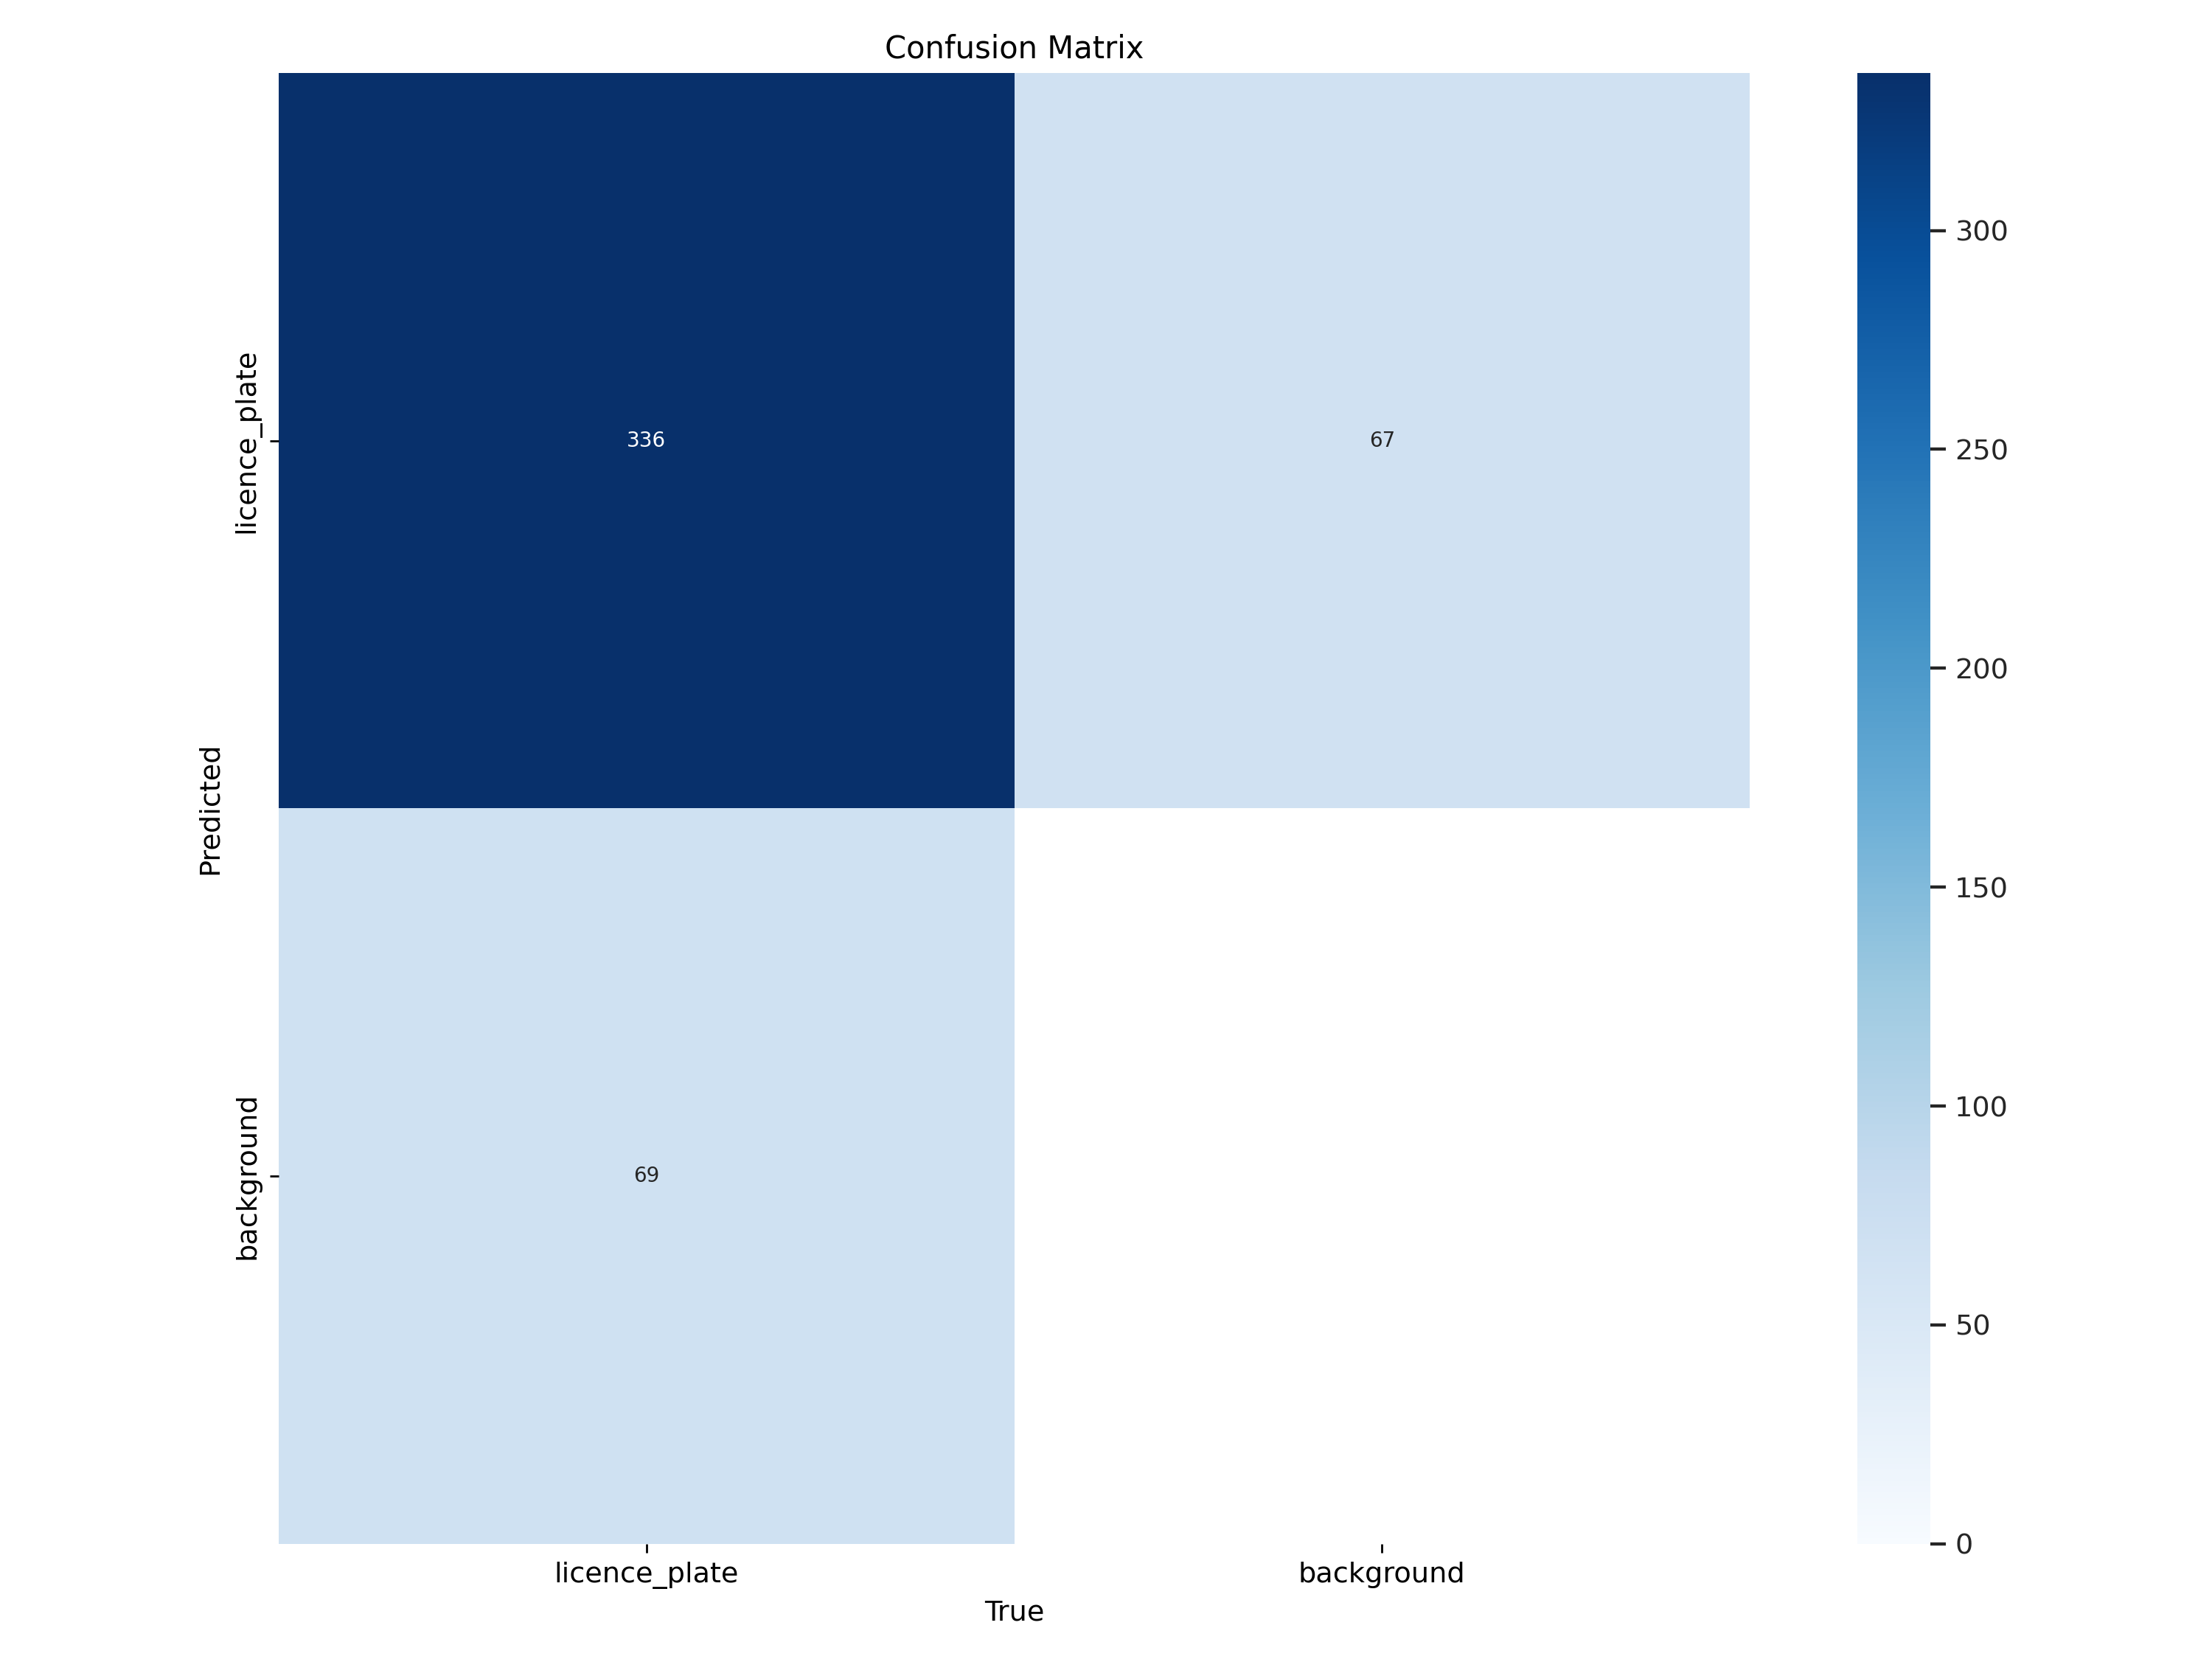

In [ ]:
Image(filename='/content/runs/detect/yolov8n_v8_licence_plate_detection/confusion_matrix.png', width=800)

### Performance of model trained to licence plate recognition

The `results.png` file contains the following information about the model's performance:

`train/box_loss`, `val/box_loss` - metrics quantify how well the predicted bounding boxes align with the ground truth bounding boxes (on the training and validation set, respectively)

`train/cls_loss`, `val/cls_loss` - metrics quantify how well the predicted class probabilities align with the ground truth class labels (on the training and validation set, respectively)

`train/dfl_loss`, `val/dfl_loss` - Distribution Focal Loss (DFL) is a modified version of the traditional Focal Loss which was originally created to solve the problem of class imbalance in object detection tasks, but in YOLOv8 it is used in the context of bounding box regression (to enhance the precision of bounding box prediction)

`metrics/precision(B)` - it quantifies the proportion of true positives among all positive predictions (i.e. it tells us what percentage of the results that were predicted to be positive were correctly classified)

`metrics/recall(B)` - it quantifies the proportion of true positives among all actual positives (i.e. it tells us what percentage of actual positive cases were correctly classified by the model)

`metrics/mAP50(B)` - it is a measure of the average precision of object detection predictions at a 50% IoU threshold for bounding boxes

`metrics/mAP50-95(B)` - it is a comprehensive measure of the average precision of object detection predictions across a range of IoU thresholds from 50% to 95% for bounding boxes

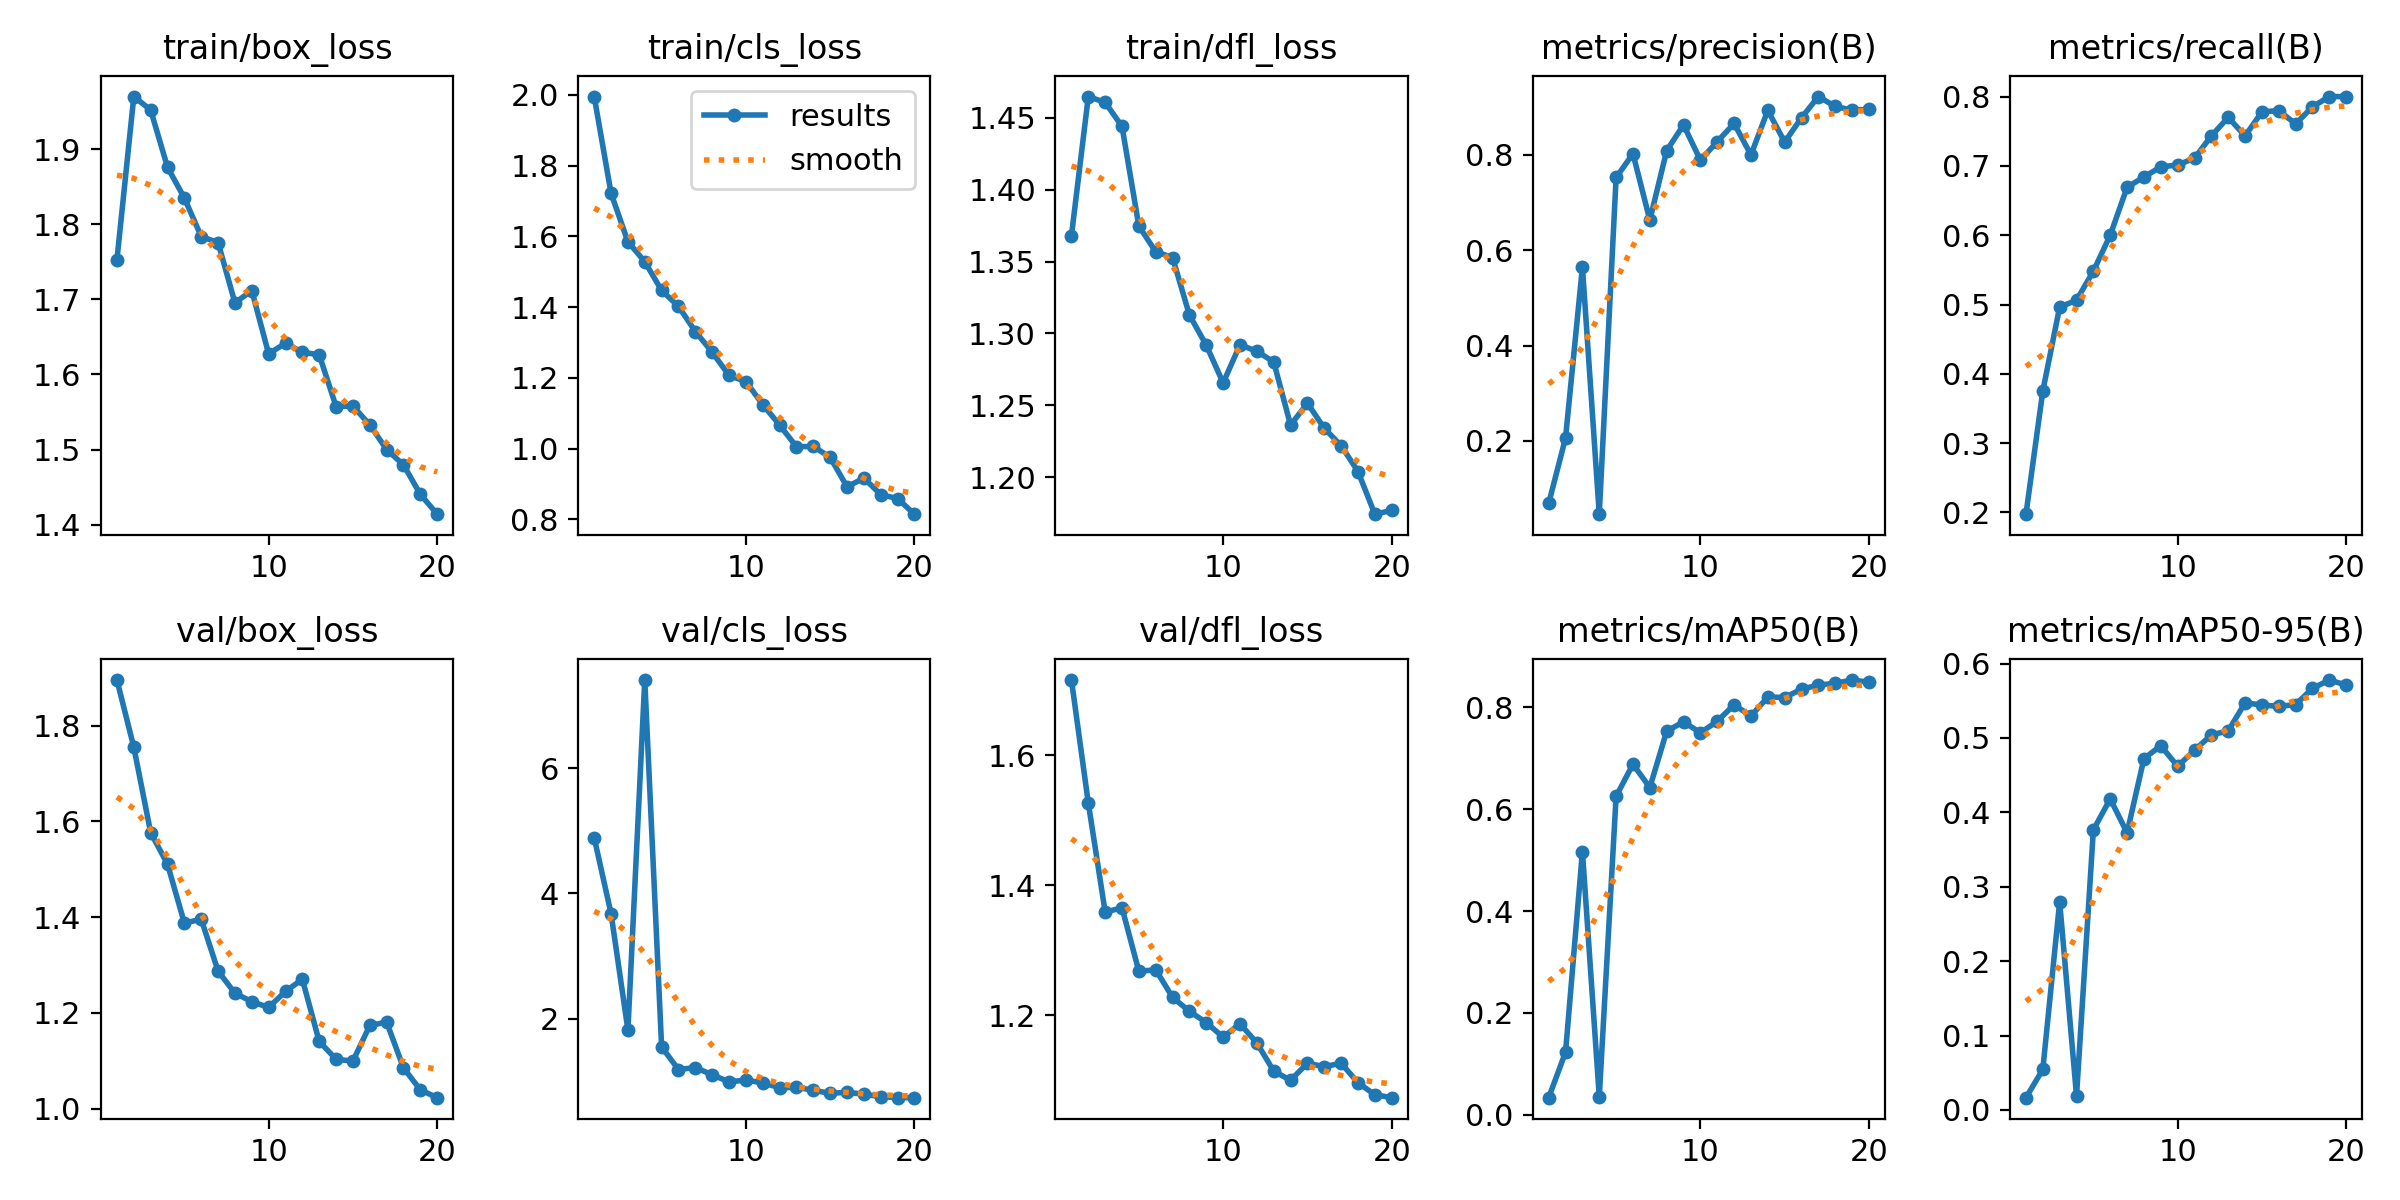

In [ ]:
Image(filename='/content/runs/detect/yolov8n_v8_licence_plate_detection/results.png', width=800)

### Pothole recognition
Training the model to recognize potholes can be done in a similar way as was done above.

The model prediction will be performed on a video with a rather high resolution and the potholes are rather small sized objects, so in order to improve the effectiveness of the model the image size during training should be set to `imgsz=1280` (twice the default value of YOLOv8) and number of epochs to at least `epochs=40`. However, in order to speed up the training process (due to limited GPU access), the following values were adopted for the listed parameters: `imgsz=640`, `epochs=30`. Of course, this will translate into significantly lower model accuracy, but does not affect the overall description of the model preparation process.

Training of the model was performed on a set of `7241` photos divided into a training set (`6970` photos) and a validation set (`271` photos).

This time we have the following `YAML` file.

```
train: '/content/drive/.../pothole_dataset_v8/train/'
val: '/content/drive/.../pothole_dataset_v8/valid/'
nc: 1
names:
  0: 'pothole'
```

In `train` method we set the parameters in a similar way as was done in the above case.

In [ ]:
# Training model for pothole detection.
trained_model = pothole_model.train(
   data='/content/drive/MyDrive/yolo/pothole_detection_v8.yaml',
   imgsz=640,
   epochs=30,
   batch=8,
   name='yolov8n_v8_pothole_detection'
)

Training was conducted in another notebook therefore only the result (Confusion Matrix and relevant metrics) is presented here.

### Confusion matrix for model trained to recognize potholes

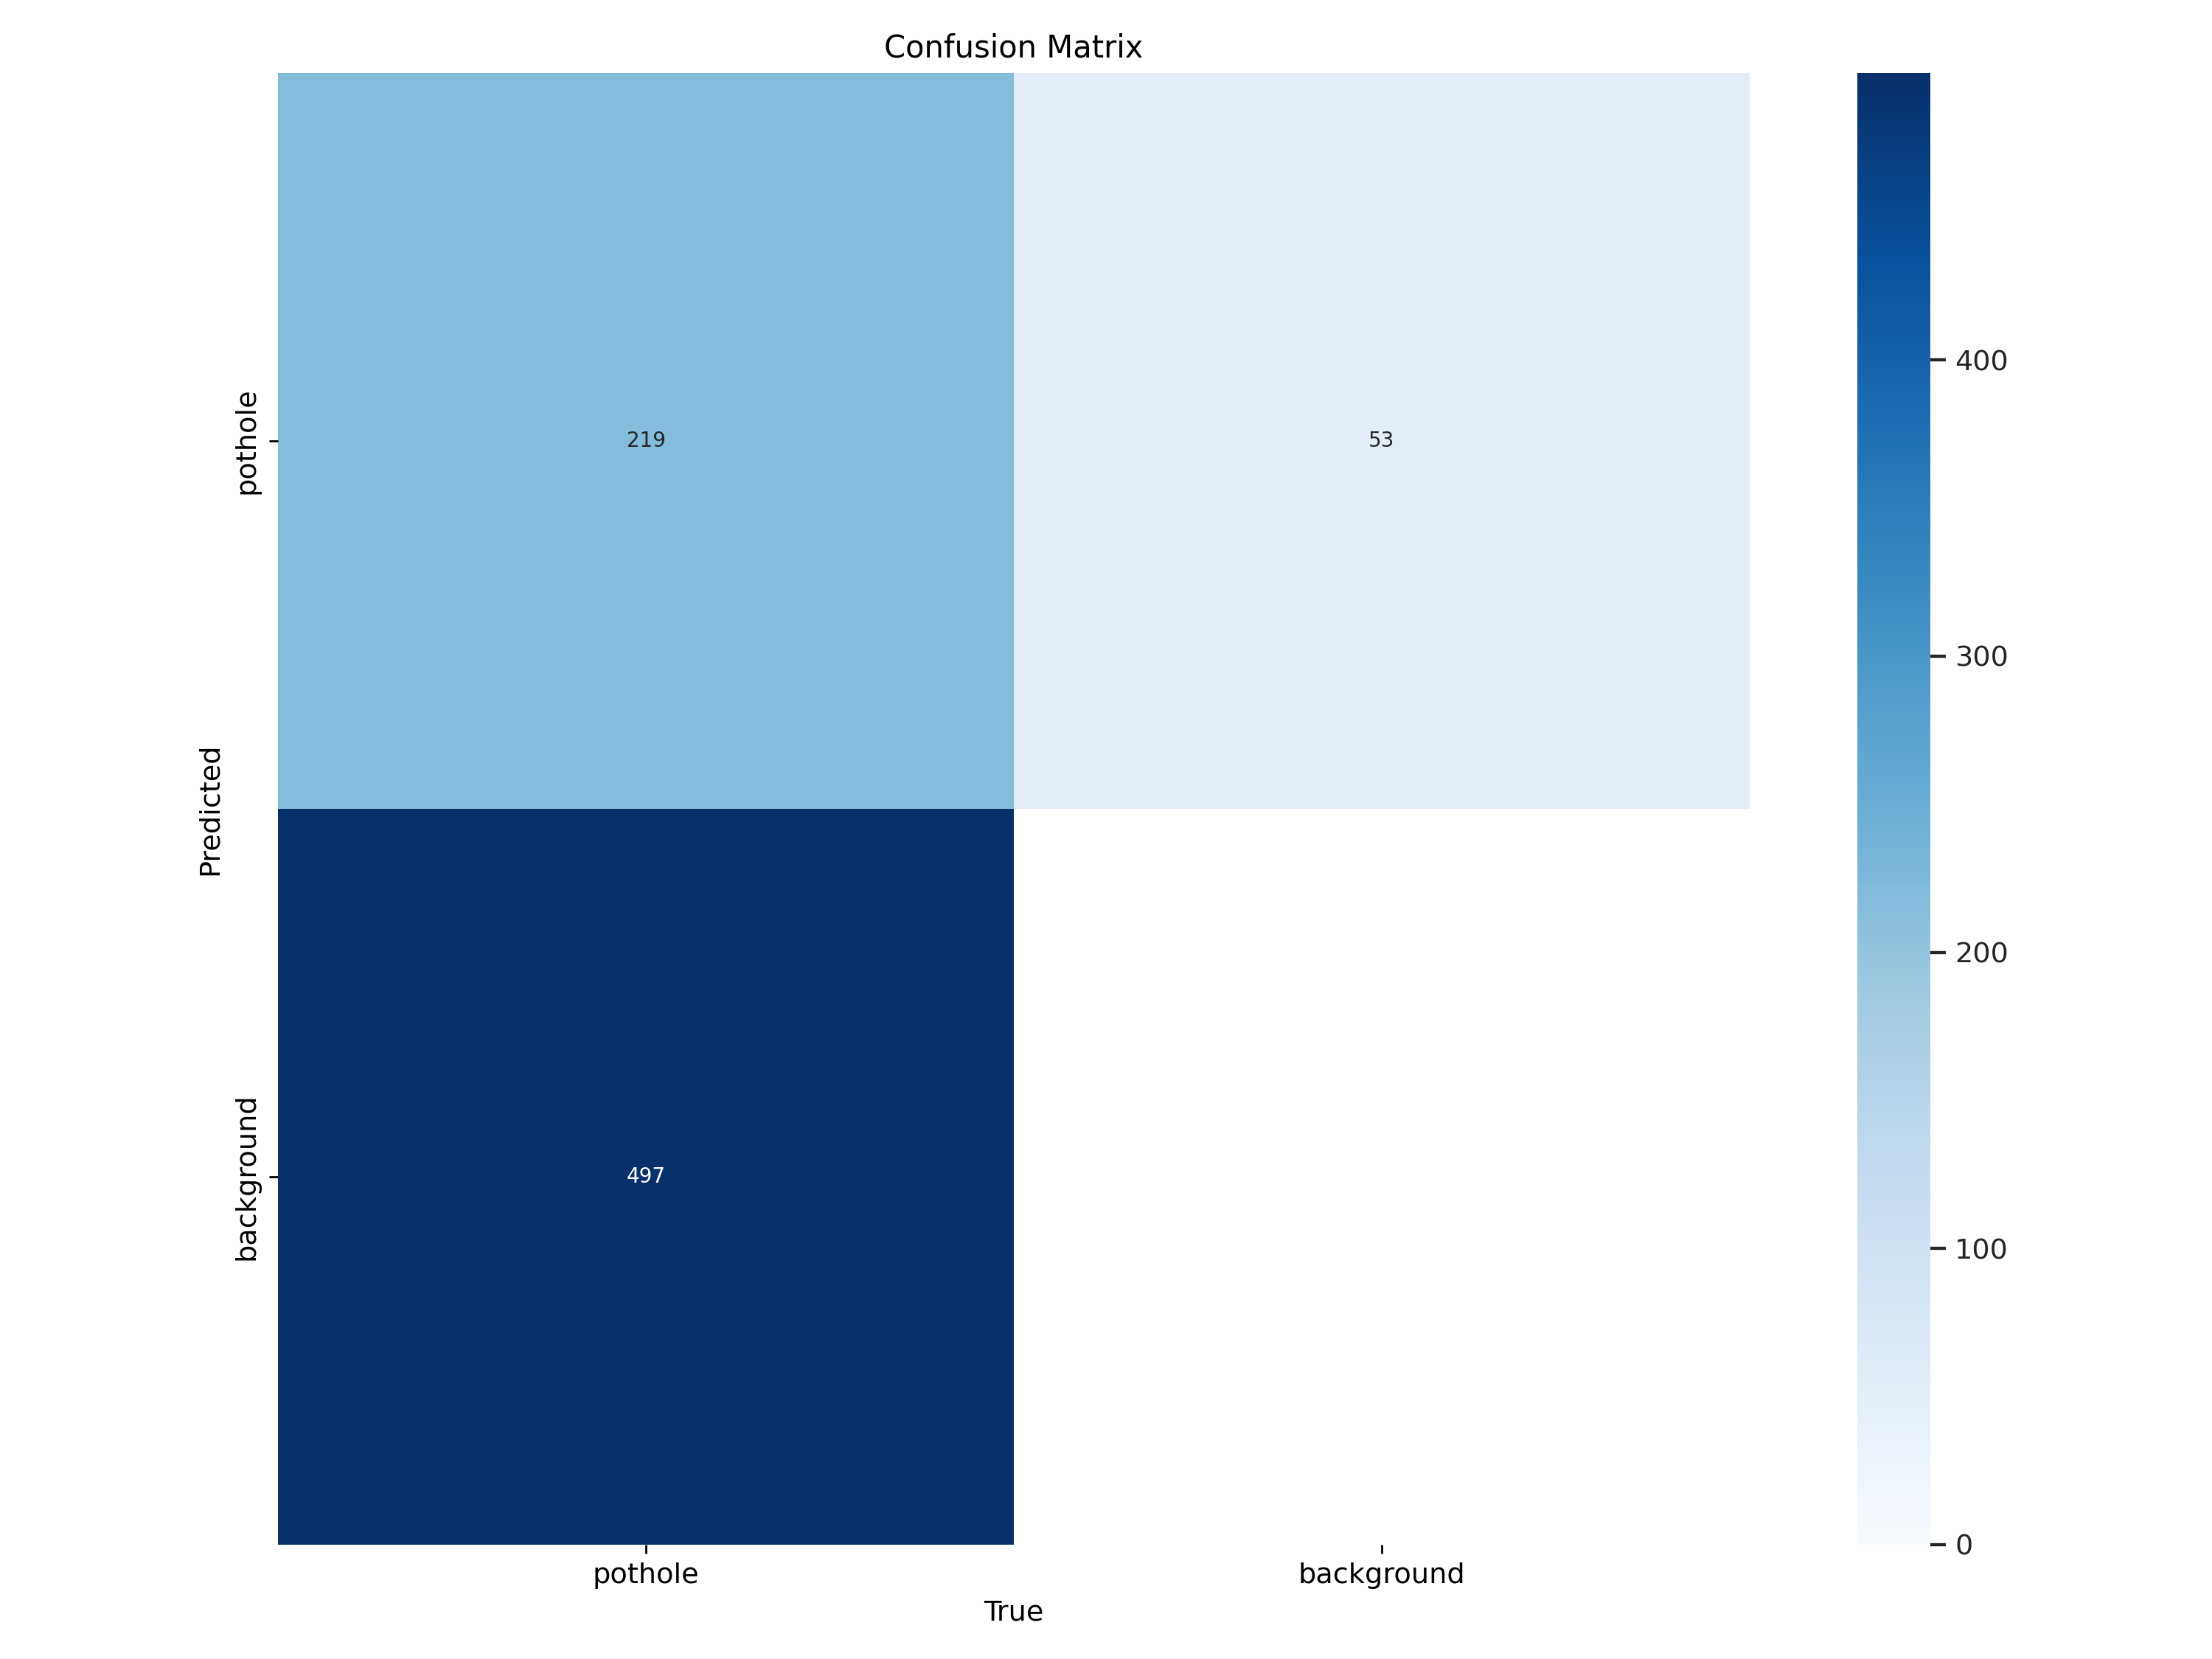

In [ ]:
Image(filename='/content/drive/MyDrive/yolo/runs/detect/yolov8_pothole_30_epochs/confusion_matrix.png', width=800)

### Performance of model trained to pothole recognition

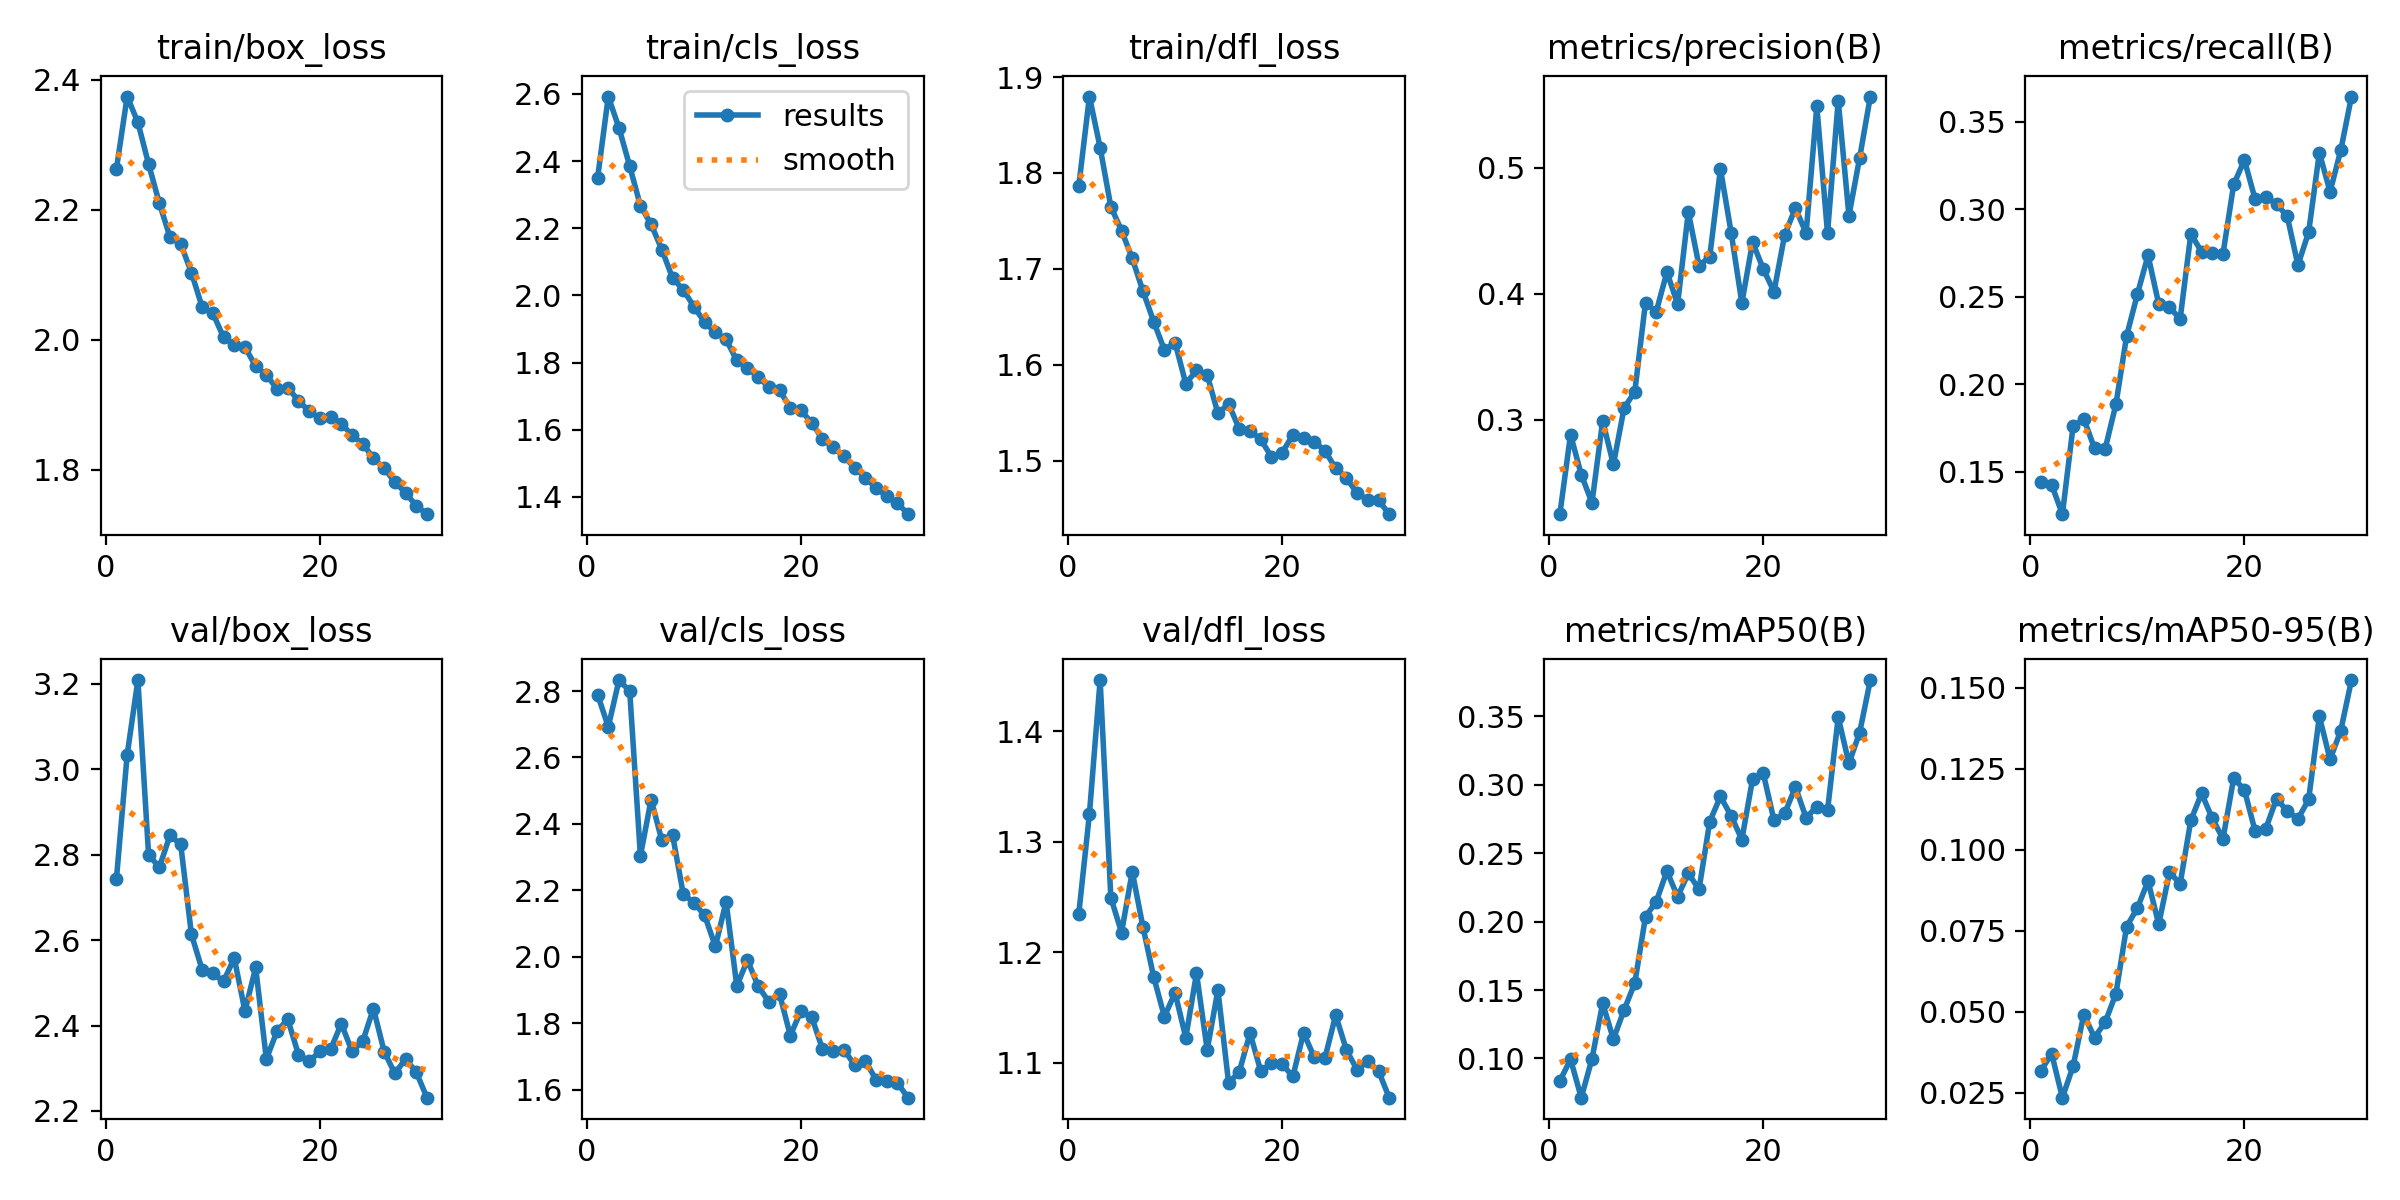

In [ ]:
Image(filename='/content/drive/MyDrive/yolo/runs/detect/yolov8_pothole_30_epochs/results.png', width=800)

As you can see, the results are not satisfactory, but this is due to the reasons already mentioned.

# Preparation of code to handle the process of object detection and counting

### The Config class stores application parameters for fixed values.
The `YOLOv8l` model was used for person detection. For person detection we use original `YOLO` model which is pretrained on the `COCO` dataset. `COCO` dataset contains such a class as `person` therefore this model should correctly detect persons.

The `YOLOv8m` model was used for license plate recognition, which was further trained on a set of `1500` license plate images. To use the trained model we refer to the file `best.pt` in the `weights` directory. The `best.pt` file contains the weights of the model that achieved the best performance on a validation set during training.

The `YOLOv8m` model was used for pothole recognition, which was further trained on a set of `6970` pothole images. Like in the case above to use the trained model (the weights of the model that achieved the best performance on a validation set) we refer to the file `best.pt` in the `weights` directory.

In [ ]:
@dataclass(frozen=True)
class Config:
  """
  Configuration class for storing application settings and constant parameters.
  """

  # Path to the person detection model file
  PERSON_DETECTION_MODEL = '/content/yolov8l.pt'
  # Path to the license plate detection model file
  LICENCE_PLATE_DETECTION_MODEL = '/content/drive/MyDrive/yolo/runs/detect/yolov8_licence_plate/weights/best.pt'
  # Path to the pothole detection model file
  POTHOLE_DETECTION_MODEL = '/content/drive/MyDrive/yolo/runs/detect/yolov8_pothole_30_epochs/weights/best.pt'
  # Coordinates of the starting point of the line marking the area of the hole size classification
  START_LINE = (100, 1200)
  # Coordinates of the ending point of the line marking the area of the hole size classification
  END_LINE = (2450, 1200)
  # Size of the image on which the model will perform the prediction
  IMGSZ = (1600, 2560)
  # Kernel size for blurring images (Odd number required)
  KSIZE = (35, 35)
  # The diameter of the pothole above which the pothole will be classified as large
  POTHOLE_SIZE = 150
  # Maximum age for objects tracked by the DeepSort tracker
  MAX_TRACKER_AGE = 50
  # Maximum length of each deque storing tracking points
  MAX_DEQUE_LENGHT = 32
  # Maximum number of deques used for tracking
  MAX_DEQUE_COUNT = 1000

### The VideoTools class contains methods useful for operating on video files
Methods:
- `get_video` - open a video file specified by the given path
- `get_extracted_video` - extracts a portion of a video file and returns a VideoCapture object for the extracted video
- `get_video_params` - retrieve such parameters of a video like: frame height and width, fps, frame count
- `display_video_info` - display information about the given video
- `create_video_writer` - create a VideoWriter object to write processed video frames

In [ ]:
class VideoTools():
  """
  A utility class for working with video files.

  This class provides static methods to perform various operations
  on video files, such as loading videos and extracting frames.
  """

  @staticmethod
  def get_video(path):
    """
    Open a video file specified by the given path.

    Args:
        path (str): Path to the video file.

    Returns:
        cv2.VideoCapture: VideoCapture object for passed video

    Raises:
        ValueError: If the video file cannot be opened.
    """
    file = cv2.VideoCapture(path)
    if not file.isOpened():
      raise ValueError("Error: Video file cannot be opened.")
    return file

  @staticmethod
  def get_extracted_video(path, start_time, end_time, output_path=None):
    """
    Extracts a portion of a video file and returns a VideoCapture object for the extracted video.

    Args:
        path (str): Path to the input video file.
        start_time (float): Start time of the portion to extract (in seconds).
        end_time (float): End time of the portion to extract (in seconds).
        output_path (str, optional): Path to save the extracted video. If not specified, a default path is used.

    Returns:
        cv2.VideoCapture: VideoCapture object for the extracted video.

    Raises:
        ValueError: If the extracted video file cannot be opened.
    """
    if output_path is None:
      output_path = '/content/extracted_video.mp4'

    # Extract a portion of the video and save it as a new file
    ffmpeg_tools.ffmpeg_extract_subclip(path, start_time, end_time, output_path)

    # Open the extracted video file
    video_capture = cv2.VideoCapture(output_path)
    if not video_capture.isOpened():
      raise ValueError("Error: Failed to open extracted video file.")

    # Delete the extracted video file to avoid cluttering the file system
    os.remove(output_path)

    return video_capture

  @staticmethod
  def get_video_params(video):
    """
    Retrieve various parameters of a video.

    Args:
        video (cv2.VideoCapture): VideoCapture object representing the video.

    Returns:
        tuple: A tuple containing the height, width, frames per second (fps), and total frame count of the video.
    """
    height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    fps = video.get(cv2.CAP_PROP_FPS)
    frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    return height, width, fps, frame_count

  @staticmethod
  def display_video_info(video):
    """
    Display information about the given video.

    Args:
        video (cv2.VideoCapture): VideoCapture object representing the video.
    """
    height, width, fps, frame_count = VideoTools.get_video_params(video)
    seconds = round(frame_count / fps)
    video_time = datetime.timedelta(seconds=seconds)
    print(f'Original video dim: {(height, width)}')
    print(f'Video fps: {fps}')
    print(f'Number of frames: {frame_count}')
    print(f'Duration in seconds: {seconds}')
    print(f'Video time: {video_time}')

  @staticmethod
  def create_video_writer(video, output_file_path=None):
    """
    Create a VideoWriter object to write processed video frames.

    Args:
        video (cv2.VideoCapture): VideoCapture object representing the video.
        output_file_path (str): The path to save the processed video.

    Returns:
        cv2.VideoWriter: A VideoWriter object for writing video frames.
    """
    if output_file_path is None:
      output_file_path = '/content/output_video.mp4'

    height, width, fps, frame_count = VideoTools.get_video_params(video)
    fourcc = cv2.VideoWriter_fourcc(*'MP4V')
    image_size = (width, height)
    return cv2.VideoWriter(output_file_path, fourcc, fps, image_size)

### The ImageProcessor class contains methods useful for operating on images (single frames of a video file)
Methods:
- `blur_picture` - blurs regions of an image based on detections (we want to blur license plates and images of people in the processed video)
- `draw_bbox` - draw a bounding box on an image along with class name and track
- `add_description` - add descriptions onto an image

In [ ]:
class ImageProcessor:
  """
  A utility class for image processing operations.

  This class provides static methods for performing various image processing tasks,
  including blurring, calculating midpoints, and adding descriptions to images.
  """

  @staticmethod
  def blur_picture(img, detections):
    """
    Blurs regions of an image based on detections.

    Args:
        img (numpy.ndarray): Input image.
        detections (list): List of dictionaries representing detected objects.
            Each dictionary should contain a 'box' key representing the bounding box coordinates.

    Returns:
        numpy.ndarray: Image with blurred regions.
    """
    for obj in detections:
      x1,y1,x2,y2 = obj['box']
      x1, y1, x2, y2 = round(x1), round(y1), round(x2), round(y2)
      roi = img[y1:y2, x1:x2]
      blurred_roi = cv2.GaussianBlur(roi, Config.KSIZE, 0)
      img[y1:y2, x1:x2] = blurred_roi

    return img

  @staticmethod
  def draw_bbox(img, bbox, track_id):
    """
    Draw a bounding box on an image along with class name and track ID.

    Parameters:
        img: The image on which to draw the bounding box.
        bbox: A list containing the coordinates of the bounding box in the format [x1, y1, x2, y2].
        track_id: The identifier of the tracked object.

    Returns:
        img: The image with the bounding box, class name, and track id drawn on it.

    Raises:
        ValueError: If class_id is out of range.
    """
    if img is None or bbox is None or len(bbox) != 4:
      raise ValueError('Invalid input: img and bbox must be provided and bbox must be of length 4.')

    x1, y1, x2, y2 = map(int, bbox)

    # Draw the bounding box of the object and the track id
    text = str(track_id)
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 0, 255), 3)
    cv2.rectangle(img, (x1 - 1, y1 - 20),
                  (x1 + len(text) * 12, y1), (255, 0, 255), -1)
    cv2.putText(img, text, (x1 + 5, y1 - 8),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

    return img

  @staticmethod
  def add_description(img, counters, font=cv2.FONT_HERSHEY_SIMPLEX, font_scale=1.5, color=(255, 255, 255), thickness=2):
    """
    Add descriptions and counters onto an image.

    Args:
        img (numpy.ndarray): Input image.
        font (int): Font type. Default is cv2.FONT_HERSHEY_SIMPLEX.
        font_scale (float): Font scale factor. Default is 1.5.
        color (tuple): Text color specified as a tuple of three integers representing BGR values. Default is (255, 255, 255) (white).
        thickness (int): Thickness of the text. Default is 2.

    Returns:
        numpy.ndarray: Image with descriptions and counters added.
    """
    # Display the number of objects counted
    cv2.putText(img, f"Small potholes: {counters['small_pothole']}", (30, 150), font, font_scale, color, thickness)
    cv2.putText(img, f"Large potholes: {counters['large_pothole']}", (30, 200), font, font_scale, color, thickness)

    return img

### The main class that performs detection and tracking of the objects considered above. In addition to its own methods, it uses methods from the above classes: VideoTools, ImageProcessor.
Methods:
- `load_model` - load a model from a given path
- `predict` - predict the classes of objects in the given image using the provided model
- `get_bbox_params` - extract bounding box parameters (coordinates, class labels, confidences) from the results
- `convert_to_tracker_format` - convert detections to the format expected by the tracker
- `count_potholes` - counts potholes based on the bounding box and track id
- `track_detect` - perform object tracking on the given image using the provided detections and tracker

In [ ]:
class ObjectDetection():
  """
  A class for performing object detection and tracking in videos.

  This class encapsulates functionality for loading object detection models,
  predicting object bounding boxes in video frames, converting detections to
  tracker-compatible format, counting detected objects, and tracking objects
  across frames in a video stream.

  Attributes:
      video: The input video file or video stream for object detection and tracking.
  """

  def __init__(self, video):
    """
    Initialize ObjectDetection object.

    Args:
        video: Video object.
    """
    self.video = video
    self.person_model = self.load_model(Config.PERSON_DETECTION_MODEL)
    self.licence_plate_model = self.load_model(Config.LICENCE_PLATE_DETECTION_MODEL)
    self.pothole_model = self.load_model(Config.POTHOLE_DETECTION_MODEL)
    self.points = [deque(maxlen=Config.MAX_DEQUE_LENGHT) for _ in range(Config.MAX_DEQUE_COUNT)]
    self.small_pothole_counter = 0
    self.large_pothole_counter = 0
    self.small_pothole_ids = set()
    self.large_pothole_ids = set()
    self.tracked_ids = set()

  def load_model(self, path):
    """
    Load a model from the given path.

    Args:
        path (str): Path to the model file.

    Returns:
        model: The loaded model object.
    """
    model = YOLO(path)
    return model

  def predict(self, img, model, classes, verbose=False):
    """
    Predict the classes of objects in the given image using the provided model.

    Args:
        img: Input image for prediction.
        model: Model object capable of making predictions.
        classes (list): List of classes to predict by the model.
        verbose (bool, optional): Verbosity mode. Defaults to False.

    Returns:
        results: Results of the prediction.
    """
    results = model.predict(img, imgsz=Config.IMGSZ, classes=classes, device=0, verbose=verbose)
    return results

  def get_bbox_params(self, results):
    """
    Extract bounding box parameters (coordinates, class labels, confidences) from the results.

    Args:
        results: The results of object detection.

    Returns:
        detections: A list of dictionaries containing bounding box parameters.
            Each dictionary contains keys 'box', 'class', and 'conf'.
    """
    boxes = results[0].boxes.xyxy.cpu().numpy()
    classes = results[0].boxes.cls.cpu().numpy()
    confs = results[0].boxes.conf.cpu().numpy()

    detections = []
    for box, cls, conf in zip(boxes, classes, confs):
      detection = {
          'box': box,
          'class': cls,
          'conf': conf
      }
      detections.append(detection)
    return detections

  def convert_to_tracker_format(self, detections):
    """
    Convert detections to the format expected by the tracker.

    Args:
        detections (list): A list of dictionaries containing detection information.

    Returns:
        list: A list of detections in the format [bbox, confidence, class_id].
    """
    results = []
    for obj in detections:
      xmin, ymin, xmax, ymax = obj['box']
      confidence = obj['conf']
      class_id = int(obj['class'])
      bbox_width = xmax - xmin
      bbox_height = ymax - ymin
      results.append([[xmin, ymin, bbox_width, bbox_height], confidence, class_id])
    return results

  def count_potholes(self, bbox, track_id):
    """
    Counts potholes based on the bounding box and track id.

    Args:
        bbox (tuple): Bounding box coordinates (x1, y1, x2, y2).
        track_id (int): Unique identifier for the object track.

    Returns:
        None
    """
    x1, y1, x2, y2 = int(bbox[0]), int(bbox[1]), int(bbox[2]), int(bbox[3])
    # Calculate the centre point coordinates and bounding box length
    length = max(int(x2 - x1), int(y2 - y1))
    center_x = int((x1 + x2) / 2)
    center_y = int((y1 + y2) / 2)
    # Append center point and length to the points list
    self.points[track_id].append((center_x, center_y, length))

    # Get the last point from the points list
    last_point_x = self.points[track_id][0][0]
    last_point_y = self.points[track_id][0][1]

    # Check conditions for counting potholes
    if (track_id not in self.tracked_ids and
            center_y > Config.START_LINE[1] and
            Config.START_LINE[0] < center_x < Config.END_LINE[0] and
            last_point_y < Config.START_LINE[1]):
      if length <= Config.POTHOLE_SIZE:
        self.small_pothole_ids.add(track_id)
        self.large_pothole_ids.discard(track_id)
        self.points[track_id].clear()
        self.tracked_ids.add(track_id)
      else:
        self.small_pothole_ids.discard(track_id)
        self.large_pothole_ids.add(track_id)
        self.points[track_id].clear()
        self.tracked_ids.add(track_id)
      self.small_pothole_counter = len(self.small_pothole_ids)
      self.large_pothole_counter = len(self.large_pothole_ids)

  def track_detect(self, img, detections, tracker):
    """
    Perform object tracking on the given image using the provided detections and tracker.

    Args:
        img: The input image for object tracking.
        detections (list): A list of detections in the format [[xmin, ymin, w, h], confidence, class_id].
        tracker: The object tracker used for tracking.

    Returns:
        img: The input image with object tracking results.
    """
    # Update the tracker with the new detections
    tracks = tracker.update_tracks(detections, frame=img)

    # Loop over the tracks
    for track in tracks:
      if not track.is_confirmed() or track.time_since_update > 1:
        continue
      # Get the bounding box of the object, the name of the object, and the track id
      bbox = track.to_tlbr()
      track_id = int(track.track_id)

      # Draw the bounding box of the object and the track id
      img = ImageProcessor.draw_bbox(img, bbox, track_id)

      self.count_potholes(bbox, track_id)

    counters = {
        'small_pothole': self.small_pothole_counter,
        'large_pothole': self.large_pothole_counter
    }

    # Display the results
    img = ImageProcessor.add_description(img, counters)

    return img

  def __call__(self):
    """
    Process the video by reading frames, making predictions, processing frames, tracking objects, and saving the output video.

    Returns:
        None
    """
    tracker = DeepSort(max_age=Config.MAX_TRACKER_AGE)
    output_video = VideoTools.create_video_writer(self.video)

    frame_count = int(self.video.get(cv2.CAP_PROP_FRAME_COUNT))
    for _ in tqdm(range(frame_count)):
      success, frame = self.video.read()
      assert success, 'Failed to read a frame'

      person_results = self.predict(frame, self.person_model, 0, False)
      person_boxes = self.get_bbox_params(person_results)

      licence_plate_results = self.predict(frame, self.licence_plate_model, None, False)
      licence_plate_boxes = self.get_bbox_params(licence_plate_results)

      frame = ImageProcessor.blur_picture(frame, person_boxes)
      frame = ImageProcessor.blur_picture(frame, licence_plate_boxes)

      pothole_results = self.predict(frame, self.pothole_model, None, False)
      pothole_boxes = self.get_bbox_params(pothole_results)
      pothole_tracker_boxes = self.convert_to_tracker_format(pothole_boxes)
      frame = self.track_detect(frame, pothole_tracker_boxes, tracker)

      # Saving transformed frames in an output video format
      output_video.write(frame)

    #Releasing the video
    output_video.release()
    cv2.destroyAllWindows()

### Running the application for a given video file

In [ ]:
video_path = 'path_to_video_file'
video = VideoTools.get_video(video_path)
# Or you can use just a portion of the video
# video = VideoTools.get_extracted_video(video_path, 30, 150)
VideoTools.display_video_info(video)
detection = ObjectDetection(video)
detection()

### Conclusions

The pothole recognition model did not achieve satisfactory results, so it is required to repeat the model training on the same data set, but with different parameters (`imgsz=1280` and the number of `epochs` greater than 30).
